In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import string

No data available for option: Under 8.5 Goals. Skipping...
No data available for option: Under 8.5 Goals. Skipping...
No data available for option: Under 8.5 Goals. Skipping...
No data available for option: Under 8.5 Goals. Skipping...
No data available for option: Under 7.5 Goals. Skipping...


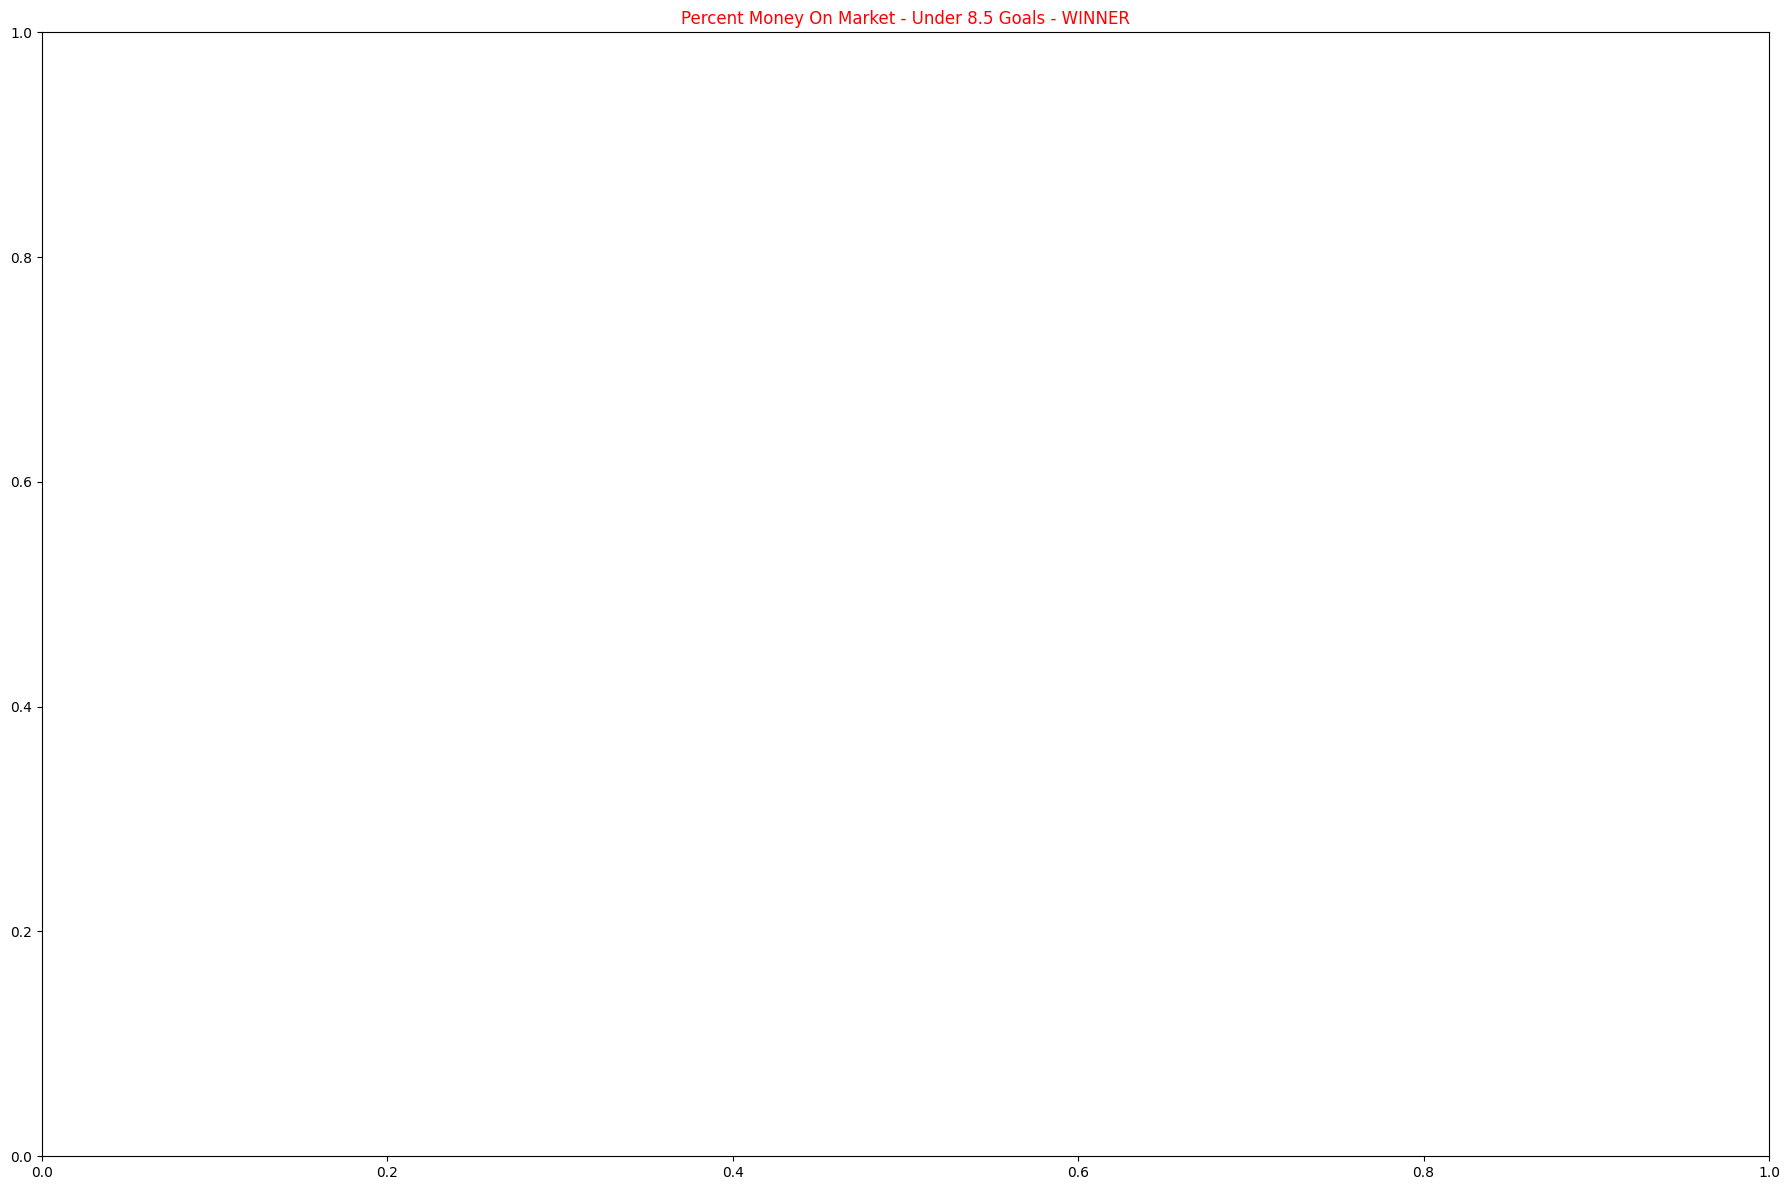

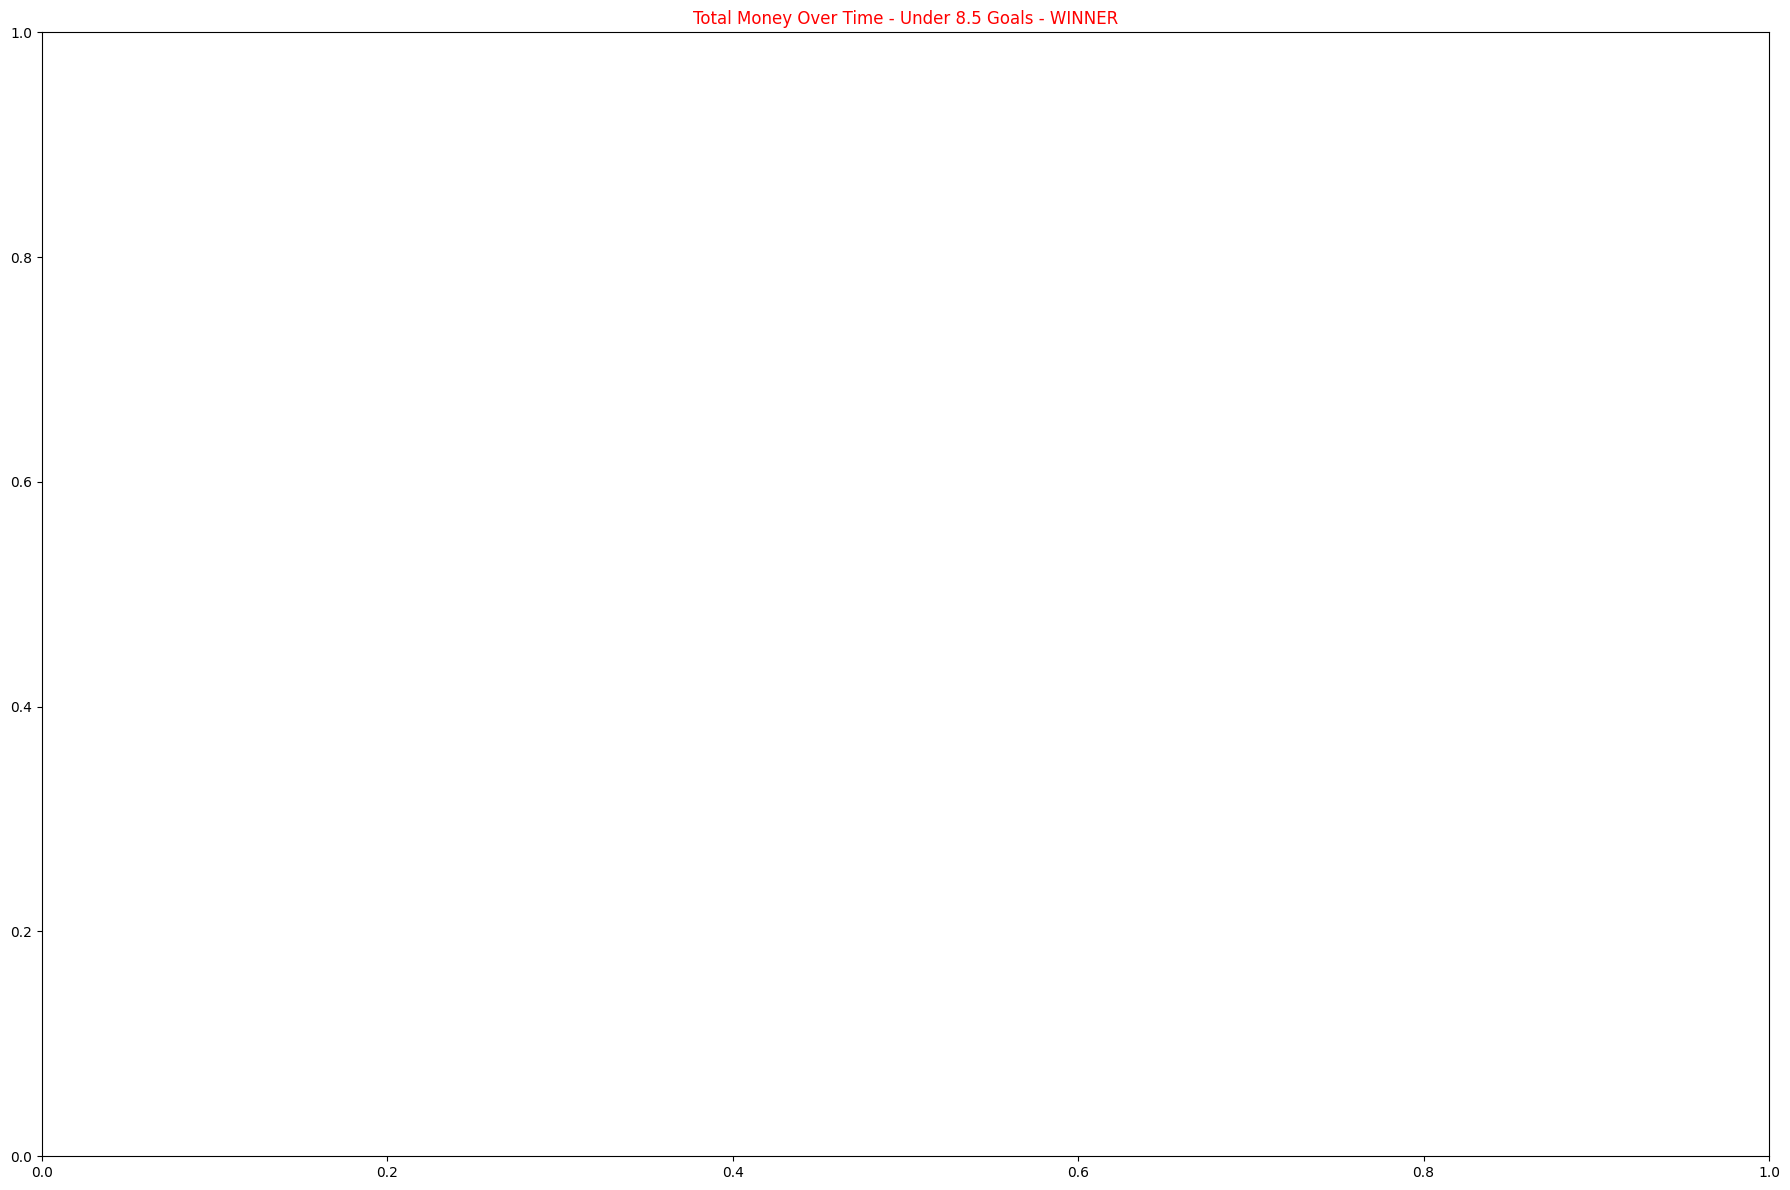

In [2]:
# Define the folder path containing event folders
event_folders = "/Users/noahroni/Documents/Test/Event_Folders"

# Iterate over all event folders
for event_folder in os.listdir(event_folders):
    # Construct the full path to the event folder
    folder_path = os.path.join(event_folders, event_folder)
    
    # Check if the item in the event_folders is a folder
    if os.path.isdir(folder_path):
        # Get the list of all files in the event folder
        file_list = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
        
        ### for all market in one event 
        ### Price and Volume Over Time

        # Process each CSV file in the event folder
        for file_name in file_list:
            # Extract the part within parentheses from the file name
            folder_name = re.search(r'\((.*?)\)', file_name).group(1)

            # Remove the ".csv" extension from the file name
            file_name_without_extension = os.path.splitext(file_name)[0]
            
            # Construct the full file path
            file_path = os.path.join(folder_path, file_name)
            
            # Read the file into a DataFrame
            df = pd.read_csv(file_path, encoding='latin1')
                
            # Convert the 'selection_md.name' column to text format
            df['selection_md.name'] = df['selection_md.name'].astype(str)
            
            # Get the unique options available in the 'selection_md.name' column
            options = df['selection_md.name'].unique()

            # Iterate over each option
            for option in options:
                #print(option)
                
                # Filter the DataFrame based on the selected option
                filtered_df = df[df['selection_md.name'] == option]

                filtered_df = filtered_df[(filtered_df['percent_money_on_market'] != 0)]
                filtered_df = filtered_df[(filtered_df['selection_ex.availableToBack.price'] != 0) & (filtered_df['selection_ex.availableToBack.price'].notna())]

                # Check if the filtered DataFrame is not empty
                if not filtered_df.empty:
                    # Extract relevant columns from the filtered DataFrame
                    time_data = filtered_df['publishTime']
                    price_data = filtered_df['selection_ex.availableToBack.price']
                    volume_data = filtered_df['selection_ex.availableToBack.size']
                    
                    # Sort the time data
                    time_data_sorted, price_yes_data_sorted, volume_yes_data_sorted = zip(*sorted(zip(time_data, price_data, volume_data)))
                    
                    # Plot the chart
                    fig, ax1 = plt.subplots(figsize=(18, 12))
                    ax1.plot(time_data_sorted, price_yes_data_sorted, label='Price', linestyle='-', color='green')
                    ax1.set_ylabel('Price')
                    ax1.set_xlabel('Time')
                    ax1.tick_params(axis='x', labelrotation=90)
                    
                    ax2 = ax1.twinx()
                    ax2.bar(time_data_sorted, volume_yes_data_sorted, label='Volume', color='blue', alpha=0.5)
                    ax2.set_ylabel('Volume', color='blue')
                    ax2.tick_params(axis='y', labelcolor='blue')
                    
                    # Check if selection_status includes "WINNER" or "LOSER"
                    status = ""
                    if "WINNER" in filtered_df['selection_status'].values:
                        status = "WINNER"
                    elif "LOSER" in filtered_df['selection_status'].values:
                        status = "LOSER"
                    
                    # Construct the title including status
                    plt_title = f'Price and Volume Over Time - {option}'
                    if status:
                        plt_title += f" - {status}"
                        plt_title_color = 'red' if status == "WINNER" else 'blue'  # Set title color based on status
                    else:
                        plt_title_color = 'black'
                    
                    plt.title(plt_title, color=plt_title_color)
                    plt.tight_layout()
                    
                    # Define the output folder paths
                    graphs_folder = os.path.join(folder_path, "Price_and_Volume_graphs")
                    if not os.path.exists(graphs_folder):
                        os.makedirs(graphs_folder)

                    # Create a folder for each file
                    output_folder = os.path.join(graphs_folder, folder_name)
                    if not os.path.exists(output_folder):
                        os.makedirs(output_folder)

                    # Remove characters that are not allowed in filenames
                    valid_chars = "-_.() %s%s" % (string.ascii_letters, string.digits)
                    option_filename = ''.join(c for c in option if c in valid_chars)
                    
                    # Define the output file path for the current option
                    output_file = os.path.join(output_folder, f'{option_filename}.png')

                    # Plot and save the graph for the current option
                    plt.savefig(output_file)

                    #plt.show()
                    plt.close()

                else:
                    print(f"No data available for option: {option}. Skipping...")

### Percent Money Over Time 
### Each option on one graph



                
            # Convert the 'selection_md.name' column to text format
            df['selection_md.name'] = df['selection_md.name'].astype(str)
            
            # Get the unique options available in the 'selection_md.name' column
            options = df['selection_md.name'].unique()
            
            # Iterate over each option
            for option in options:
                #print(option)
                
                # Filter the DataFrame based on the selected option
                filtered_df = df[df['selection_md.name'] == option]

                # Plot the chart
                fig, ax1 = plt.subplots(figsize=(18, 12))

                # Check if selection_status includes "WINNER" or "LOSER"
                status = ""
                if "WINNER" in filtered_df['selection_status'].values:
                    status = "WINNER"
                elif "LOSER" in filtered_df['selection_status'].values:
                    status = "LOSER"
                        
                # Construct the title including status
                plt_title = f'Percent Money On Market - {option}'
                if status:
                    plt_title += f" - {status}"
                    plt_title_color = 'red' if status == "WINNER" else 'blue'  # Set title color based on status
                else:
                    plt_title_color = 'black'
                        
                plt.title(plt_title, color=plt_title_color)
                plt.tight_layout()

                filtered_df = filtered_df[(filtered_df['percent_money_on_market'] != 0) & (filtered_df['percent_money_on_market'].notna())]
                
                # Check if the filtered DataFrame is not empty
                if not filtered_df.empty:
                
                    # Extract relevant columns from the filtered DataFrame
                    time_data = filtered_df['publishTime']
                    percent_money_data = filtered_df['percent_money_on_market']          
                    
                    # Sort the time data
                    time_data_sorted, percent_money_data_sorted = zip(*sorted(zip(time_data, percent_money_data)))
                    
                    ax1.plot(time_data_sorted, percent_money_data_sorted, label=option, linestyle='-', color='green')
                    ax1.set_ylabel('Percent Money')
                    ax1.set_xlabel('Time')
                    ax1.tick_params(axis='x', labelrotation=80)
                    ax1.legend()
                    plt.tight_layout()
                    
                    # Define the output folder paths
                    graphs_folder = os.path.join(folder_path, "Percent_Money_graphs")
                    if not os.path.exists(graphs_folder):
                        os.makedirs(graphs_folder)

                    # Create a folder for each file
                    output_folder = os.path.join(graphs_folder, folder_name)
                    if not os.path.exists(output_folder):
                        os.makedirs(output_folder)

                    # Remove characters that are not allowed in filenames
                    valid_chars = "-_.() %s%s" % (string.ascii_letters, string.digits)
                    option_filename = ''.join(c for c in option if c in valid_chars)
                    
                    # Define the output file path for the current option
                    output_file = os.path.join(output_folder, f'{option_filename}.png')

                    # Plot and save the graph for the current option
                    plt.savefig(output_file)

                    #plt.show()
                    plt.close()

                else:
                    print(f"No data available for option: {option}. Skipping...")

### All options on one graph

        
            # Convert the 'selection_md.name' column to text format
            df['selection_md.name'] = df['selection_md.name'].astype(str)
            
            # Get the unique options available in the 'selection_md.name' column
            options = df['selection_md.name'].unique()

            # Plot the chart
            fig, ax1 = plt.subplots(figsize=(18, 12))

            # Iterate over each option
            for option in options:

                # Filter the DataFrame based on the selected option
                filtered_df = df[df['selection_md.name'] == option]  

                # Check if there is at least one "WINNER" in the 'selection_status' column
                if "WINNER" in filtered_df['selection_status'].values:
                    winner_count = (filtered_df['selection_status'] == "WINNER").sum()
                        
                    if winner_count == 1:
                        status = "WINNER"
                        plt_title = f'Percent Money On Market - {option} is WINNER'
                        plt_title_color = 'red'
                    elif winner_count > 1:
                        plt_title = 'Percent Money On Market - More than 1 WINNER'
                        plt_title_color = 'blue'
                    elif winner_count == 0:
                        status = "LOSER"
                        plt_title = 'Percent Money On Market - No WINNER'
                        plt_title_color ='black'  # Default title color
                
                                
                    plt.title(plt_title, color=plt_title_color)
                    plt.tight_layout()
                
                filtered_df = filtered_df[(filtered_df['percent_money_on_market'] != 0) & (filtered_df['percent_money_on_market'].notna())]
                
                # Check if the filtered DataFrame is not empty
                if not filtered_df.empty:

                    # Convert 'publishTime' to datetime
                    filtered_df['publishTime'] = pd.to_datetime(filtered_df['publishTime'])
                    # Sort the filtered DataFrame by 'publishTime'
                    filtered_df = filtered_df.sort_values(by=['publishTime'])

                    # Extract relevant columns from the filtered DataFrame
                    time_data = filtered_df['publishTime']
                    percent_money_data = filtered_df['percent_money_on_market']          
                    
                    # Sort the time data
                    time_data_sorted, percent_money_data_sorted = zip(*sorted(zip(time_data, percent_money_data)))

                    # Plot the data for the current option
                    ax1.plot(time_data_sorted, percent_money_data_sorted, label=option, linestyle='-')
                    plt.tight_layout()

                    

            # Set labels and title
            ax1.set_xlabel('Time')
            ax1.set_ylabel('Percent Money')
            ax1.tick_params(axis='x', labelrotation=75)
            # Format the x-axis tick labels
            ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
            date_format = mdates.DateFormatter('%d:%m:%Y %H:%M:%S')
            ax1.xaxis.set_major_formatter(date_format)
            ax1.legend(loc='upper right')
            plt.tight_layout()

            # Define the output folder paths
            graphs_folder = os.path.join(folder_path, "Percent_Money_graphs")
            if not os.path.exists(graphs_folder):
                os.makedirs(graphs_folder)

                    # Create a folder for each file
            output_folder = os.path.join(graphs_folder, folder_name)
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)

                    # Define the output file path
            output_file = os.path.join(output_folder, f'{file_name_without_extension}.png')

                    # Save the graph
            plt.savefig(output_file)

            #plt.show()
            plt.close()

### Total Money Over Time 
### Each optin on one graph
                
            # Convert the 'selection_md.name' column to text format
            df['selection_md.name'] = df['selection_md.name'].astype(str)
            
            # Get the unique options available in the 'selection_md.name' column
            options = df['selection_md.name'].unique()

            # Iterate over each option
            for option in options:
                #print(option)
                
                # Filter the DataFrame based on the selected option
                filtered_df = df[df['selection_md.name'] == option]

                # Plot the chart
                fig, ax1 = plt.subplots(figsize=(18, 12))

                # Check if selection_status includes "WINNER" or "LOSER"
                status = ""
                if "WINNER" in filtered_df['selection_status'].values:
                    status = "WINNER"
                elif "LOSER" in filtered_df['selection_status'].values:
                    status = "LOSER"
                        
                        # Check if selection_status includes "WINNER" or "LOSER"
                status = ""
                if "WINNER" in filtered_df['selection_status'].values:
                    status = "WINNER"
                elif "LOSER" in filtered_df['selection_status'].values:
                    status = "LOSER"
                        
                # Construct the title including status
                plt_title = f'Total Money Over Time - {option}'
                if status:
                    plt_title += f" - {status}"
                    plt_title_color = 'red' if status == "WINNER" else 'blue'  # Set title color based on status
                else:
                    plt_title_color = 'black'
                        
                plt.title(plt_title, color=plt_title_color)
                plt.tight_layout()

                # Filter out rows with 0 value in 'percent_money_on_market' column
                filtered_df = filtered_df[(filtered_df['selection_totalMatched'] != 0) & (filtered_df['selection_totalMatched'].notna())]

                
                # Check if the filtered DataFrame is not empty
                if not filtered_df.empty:

                    # Extract relevant columns from the filtered DataFrame
                    time_data = filtered_df['publishTime']
                    money_data = filtered_df['selection_totalMatched']
                    
                    # Sort the time data
                    time_data_sorted, money_data_sorted = zip(*sorted(zip(time_data, money_data)))
                    
                    # Plot the chart
                    
                    ax1.plot(time_data_sorted, money_data_sorted, label=option, linestyle='-', color='green')
                    ax1.set_ylabel('Money')
                    ax1.set_xlabel('Time')
                    ax1.tick_params(axis='x', labelrotation=80)
                    ax1.legend()
                    plt.tight_layout()

                    # Define the output folder paths
                    graphs_folder = os.path.join(folder_path, "Total_Money_graphs")
                    if not os.path.exists(graphs_folder):
                        os.makedirs(graphs_folder)

                    # Create a folder for each file
                    output_folder = os.path.join(graphs_folder, folder_name)
                    if not os.path.exists(output_folder):
                        os.makedirs(output_folder)

                    # Remove characters that are not allowed in filenames
                    valid_chars = "-_.() %s%s" % (string.ascii_letters, string.digits)
                    option_filename = ''.join(c for c in option if c in valid_chars)
                    
                    # Define the output file path for the current option
                    output_file = os.path.join(output_folder, f'{option_filename}.png')

                    # Plot and save the graph for the current option
                    plt.savefig(output_file)

                    # Close the figure to avoid memory issues
                    plt.close()

                    #plt.show()     

                else:
                    print(f"No data available for option: {option}. Skipping...")
                    
                    # Close the figure to avoid the warning

### All options on one graph    

                
            # Convert the 'selection_md.name' column to text format
            df['selection_md.name'] = df['selection_md.name'].astype(str)
            
            # Get the unique options available in the 'selection_md.name' column
            options = df['selection_md.name'].unique()

            # Plot the chart
            fig, ax1 = plt.subplots(figsize=(18, 12))

            # Iterate over each option
            for option in options:
                
                # Filter the DataFrame based on the selected option
                filtered_df = df[df['selection_md.name'] == option]

                # Check if there is at least one "WINNER" in the 'selection_status' column
                if "WINNER" in filtered_df['selection_status'].values:
                    winner_count = (filtered_df['selection_status'] == "WINNER").sum()
                        
                    if winner_count == 1:
                        status = "WINNER"
                        plt_title = f'Total Money On Market - {option} is WINNER'
                        plt_title_color = 'red'
                    elif winner_count > 1:
                        plt_title = 'Total Money On Market - More than 1 WINNER'
                        plt_title_color = 'blue'
                    elif winner_count == 0:
                        status = "LOSER"
                        plt_title = 'Total Money On Market - No WINNER'
                        plt_title_color ='black'  # Default title color
                
                                
                    plt.title(plt_title, color=plt_title_color)
                    plt.tight_layout()

                # Filter out rows with 0 value in 'percent_money_on_market' column
                filtered_df = filtered_df[filtered_df['selection_totalMatched'] != 0]
                
                # Check if the filtered DataFrame is not empty
                if not filtered_df.empty:

                    # Convert 'publishTime' to datetime
                    filtered_df['publishTime'] = pd.to_datetime(filtered_df['publishTime'])
                    
                    # Sort the filtered DataFrame by 'publishTime'
                    filtered_df = filtered_df.sort_values(by=['publishTime'])
                    # Extract relevant columns from the filtered DataFrame
                    time_data = filtered_df['publishTime']

                    money_data = filtered_df['selection_totalMatched']

                    # Sort the time data
                    time_data_sorted, money_data_sorted = zip(*sorted(zip(time_data, money_data)))
                    
                    # Plot the data for the current option
                    ax1.plot(time_data_sorted, money_data_sorted, label=option, linestyle='-')
                    plt.tight_layout()


        # Set labels and title
            ax1.set_xlabel('Time', fontsize=12)
            ax1.set_ylabel('Total Money', fontsize=12)
            ax1.tick_params(axis='x', labelrotation=75)
            # Format the x-axis tick labels
            ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
            date_format = mdates.DateFormatter('%d:%m:%Y %H:%M:%S')
            ax1.xaxis.set_major_formatter(date_format)
            ax1.legend(loc='upper right')
            plt.tight_layout()

            # Define the output folder paths
            graphs_folder = os.path.join(folder_path, "Total_Money_graphs")
            if not os.path.exists(graphs_folder):
                os.makedirs(graphs_folder)

            # Create a folder for each file
            output_folder = os.path.join(graphs_folder, folder_name)
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)

            # Define the output file path
            output_file = os.path.join(output_folder, f'{file_name_without_extension}.png')

            # Save the graph
            plt.savefig(output_file)

            #plt.show()
            plt.close()


            

            
